In [1]:
# 1. Install libraries (nếu chạy trên Colab)
!pip install -q datasets torchcfm sentence-transformers

# 2. Load dataset
from datasets import load_dataset

ds = load_dataset("bahjat-kawar/tedbench", split="val")

# 3. Text Encoder
import torch
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_encoder = SentenceTransformer("all-mpnet-base-v2").to(device)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is

README.md:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

val-00000-of-00001.parquet:   0%|          | 0.00/133M [00:00<?, ?B/s]

Generating val split:   0%|          | 0/100 [00:00<?, ? examples/s]

2025-04-13 03:43:48.416351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744515828.650921      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744515828.722829      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [2]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class TextGuidedImageGenerationDataset(Dataset):
    def __init__(self, dataset, transform, text_encoder, device):
        self.dataset = dataset
        self.transform = transform
        self.text_encoder = text_encoder
        self.device = device
        self.original_images = dataset["original_image"]
        self.captions = dataset["caption"]
        self.edited_images = dataset["edited_image"]
        self.embed_captions = text_encoder.encode(
            self.captions, convert_to_tensor=True, device=self.device
        )

    def __len__(self):
        return len(self.captions)

    def __getitem__(self, idx):
        # get original image
        original_image = self.original_images[idx]
        if original_image.mode != 'RGB':
            original_image = original_image.convert('RGB')
        original_image = self.transform(original_image)

        # get edited image
        edited_image = self.edited_images[idx]
        edited_image = self.transform(edited_image)

        # get text
        caption = self.captions[idx]
        caption_embedding = self.embed_captions[idx]

        return {
            "original_image": original_image,
            "edited_image": edited_image,
            "caption": caption,
            "caption_embedding": caption_embedding,
        }

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_ds = TextGuidedImageGenerationDataset(ds, transform, text_encoder, device)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
import math
import torch
import torch.nn as nn
from torchcfm.models.unet import UNetModel

def timestep_embedding(timesteps, dim, max_period=10000):
    """Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element. These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period)
        * torch.arange(start=0, end=half, dtype=torch.float32, device=timesteps.device)
        / half
    )
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding

class UNetModelWithTextEmbedding(UNetModel):
    def __init__(self, dim, num_channels, num_res_blocks, embedding_dim, *args, **kwargs):
        super().__init__(dim, num_channels, num_res_blocks, *args, **kwargs)

        self.image_encoder = nn.Sequential(
            nn.Conv2d(3, num_channels, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels, num_channels * 2, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(num_channels * 2, num_channels * 4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )

        self.embedding_layer = nn.Linear(embedding_dim, num_channels * 4)
        self.fc = nn.Linear(num_channels * 12, num_channels * 4)

    def forward(self, t, x, text_embeddings=None, original_image=None):
        """Apply the model to an input batch, incorporating text embeddings."""
        timesteps = t

        while timesteps.dim() > 1:
            timesteps = timesteps[:, 0]
        if timesteps.dim() == 0:
            timesteps = timesteps.repeat(x.shape[0])

        hs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        if (text_embeddings is not None) and (original_image is not None):
            text_embedded = self.embedding_layer(text_embeddings)
            image_embedded = self.image_encoder(original_image).squeeze(2, 3)
            emb = torch.cat([emb, text_embedded, image_embedded], dim=1)
            emb = self.fc(emb)

        h = x.type(self.dtype)
        for module in self.input_blocks:
            h = module(h, emb)
            hs.append(h)

        h = self.middle_block(h, emb)

        for module in self.output_blocks:
            h = torch.cat([h, hs.pop()], dim=1)
            h = module(h, emb)

        h = h.type(x.dtype)
        return self.out(h)


In [4]:
from tqdm import tqdm
import torch

# Khởi tạo mô hình
model = UNetModelWithTextEmbedding(
    dim=(3, 256, 256),
    num_channels=32,
    num_res_blocks=1,
    embedding_dim=768
).to(device)

optimizer = torch.optim.Adam(model.parameters())

# Huấn luyện
n_epochs = 1000
best_loss = float("inf")
best_model_path = "best_model.pt"

for epoch in tqdm(range(n_epochs)):
    losses = []

    for sample in train_loader:
        original_image = sample["original_image"].to(device)
        edited_image = sample["edited_image"].to(device)
        caption_embedding = sample["caption_embedding"].to(device)

        optimizer.zero_grad()

        # Tạo dữ liệu huấn luyện flow
        x1 = edited_image
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(x0.shape[0], 1, 1, 1).to(device)
        xt = t * x1 + (1 - t) * x0
        ut = x1 - x0
        t = t.squeeze()

        # Dự đoán vector vận tốc
        vt = model(t, xt, text_embeddings=caption_embedding, original_image=original_image)

        # Tính loss
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    # Tính trung bình loss mỗi epoch
    avg_loss = sum(losses) / len(losses)

    # In log mỗi 500 epoch
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {avg_loss:.4f}")

    # Lưu mô hình tốt nhất
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), best_model_path)
        print(f">>> Saved best model with loss = {best_loss:.4f} at epoch {epoch + 1}")


  0%|          | 1/1000 [00:05<1:24:38,  5.08s/it]

>>> Saved best model with loss = 1.0257 at epoch 1


  0%|          | 2/1000 [00:09<1:17:27,  4.66s/it]

>>> Saved best model with loss = 0.6296 at epoch 2


  0%|          | 3/1000 [00:13<1:15:12,  4.53s/it]

>>> Saved best model with loss = 0.3950 at epoch 3


  0%|          | 4/1000 [00:18<1:14:04,  4.46s/it]

>>> Saved best model with loss = 0.2750 at epoch 4


  0%|          | 5/1000 [00:22<1:13:41,  4.44s/it]

>>> Saved best model with loss = 0.2016 at epoch 5


  1%|          | 6/1000 [00:27<1:13:37,  4.44s/it]

>>> Saved best model with loss = 0.1871 at epoch 6


  1%|          | 8/1000 [00:36<1:13:56,  4.47s/it]

>>> Saved best model with loss = 0.1640 at epoch 8


  1%|          | 9/1000 [00:40<1:13:49,  4.47s/it]

>>> Saved best model with loss = 0.1599 at epoch 9


  1%|          | 10/1000 [00:44<1:13:55,  4.48s/it]

>>> Saved best model with loss = 0.1454 at epoch 10


  1%|▏         | 14/1000 [01:03<1:14:24,  4.53s/it]

>>> Saved best model with loss = 0.1404 at epoch 14


  2%|▏         | 16/1000 [01:12<1:15:13,  4.59s/it]

>>> Saved best model with loss = 0.1268 at epoch 16


  2%|▏         | 18/1000 [01:21<1:15:34,  4.62s/it]

>>> Saved best model with loss = 0.1166 at epoch 18


  2%|▏         | 20/1000 [01:31<1:16:26,  4.68s/it]

>>> Saved best model with loss = 0.1133 at epoch 20


  2%|▏         | 22/1000 [01:40<1:17:40,  4.77s/it]

>>> Saved best model with loss = 0.0998 at epoch 22


  4%|▍         | 42/1000 [03:18<1:17:49,  4.87s/it]

>>> Saved best model with loss = 0.0995 at epoch 42


  5%|▌         | 52/1000 [04:07<1:17:29,  4.90s/it]

>>> Saved best model with loss = 0.0929 at epoch 52


  5%|▌         | 54/1000 [04:17<1:17:13,  4.90s/it]

>>> Saved best model with loss = 0.0873 at epoch 54


  6%|▋         | 64/1000 [05:06<1:17:01,  4.94s/it]

>>> Saved best model with loss = 0.0863 at epoch 64


  8%|▊         | 76/1000 [06:05<1:15:26,  4.90s/it]

>>> Saved best model with loss = 0.0848 at epoch 76


 50%|█████     | 500/1000 [40:33<40:49,  4.90s/it]

Epoch [500/1000], Loss: 1.0356


100%|██████████| 1000/1000 [1:21:13<00:00,  4.87s/it]

Epoch [1000/1000], Loss: 1.0276


In [5]:
# Chuyển sang chế độ eval
model.eval()

# Hàm Euler giải ODE từ noise đến ảnh đầu ra
def euler_method(model, text_embedding, t_steps, dt, noise, original_image):
    y = noise
    y_values = [y]

    with torch.no_grad():
        for t in t_steps[1:]:
            t = t.reshape(-1)
            dy = model(
                t.to(device),
                y,
                text_embeddings=text_embedding,
                original_image=original_image
            )
            y = y + dy * dt
            y_values.append(y)

    return torch.stack(y_values)

# Sample dữ liệu đầu vào
# Ví dụ: caption = "A photo of an open door"
sample = train_ds[5]
original_image = sample["original_image"].unsqueeze(0).to(device)
edited_image = sample["edited_image"].unsqueeze(0).to(device)
caption_embedding = sample["caption_embedding"].unsqueeze(0).to(device)

# Khởi tạo noise đầu vào
noise = torch.randn_like(original_image, device=device)
text_embedding = caption_embedding

# Thông số thời gian
t_steps = torch.linspace(0, 1, 150, device=device)
dt = t_steps[1] - t_steps[0]

# Giải ODE bằng Euler
results = euler_method(model, text_embedding, t_steps, dt, noise, original_image)

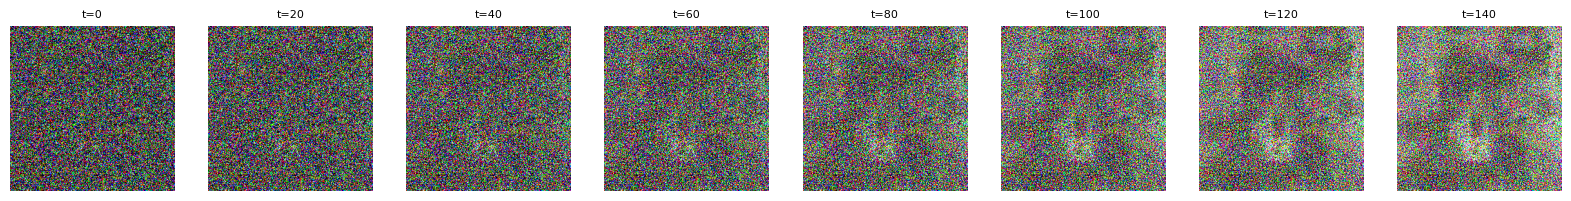

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Giả sử results có shape: (timesteps, B=1, C=3, H, W)
# Bỏ batch dim nếu B=1 → (100, 3, 64, 64)
results = results.squeeze(1).cpu()

# Chọn các bước theo t=0, 20, 40, 60, 80
selected_indices = list(range(0, results.shape[0], 20))
selected_images = [TF.to_pil_image(torch.clamp(results[i], 0, 1)) for i in selected_indices]

# Vẽ các ảnh đã chọn thành 1 hàng ngang
fig, axes = plt.subplots(1, len(selected_images), figsize=(len(selected_images) * 2, 2))
for i, ax in enumerate(axes):
    ax.imshow(selected_images[i])
    ax.axis('off')
    ax.set_title(f"t={selected_indices[i]}", fontsize=8)

plt.tight_layout()
plt.show()
